In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy

Load and plot event/earthquake signal starting around sample 6000

---



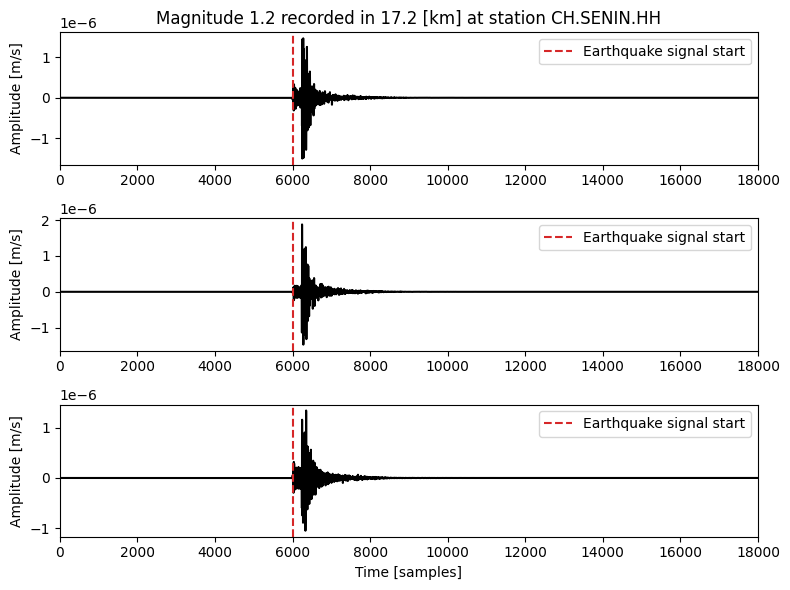

In [3]:
dir_file = "./examples/signal_2009_009_M12_D17_CH_SENIN_HHN.npz"
#dir_file = "./examples/signal_2023_068_M11_D05_CH_DIX_HHZ.npz"

data_npz = np.load(dir_file, allow_pickle=True)
data = {key: data_npz[key] for key in data_npz}

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])  # Three rows, one column

# Create the subplots
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Data for each plot
waveforms = ["earthquake_waveform_Z", "earthquake_waveform_N", "earthquake_waveform_E"]
axes = [ax1, ax2, ax3]

# Loop over axes to plot data and add common settings
for ax, waveform in zip(axes, waveforms):
    ax.plot(data[waveform], color="k")
    ax.set_xlim(0, 18000)
    ax.set_ylabel("Amplitude [m/s]")
    ax.axvline(x=6000, color='tab:red', linestyle='--', label="Earthquake signal start")
    ax.legend()

# Set x-label for the last axis
ax3.set_xlabel("Time [samples]")

ttl_str = "Magnitude " + str(data["magnitude"]) + " recorded in " + str(np.round(data["distance"],1))
ttl_str += " [km] at station " + str(data["code"][0]) + "." +str(data["code"][1]) + "." +str(data["code"][2][:2])
ax1.set_title(ttl_str)
# Display the plot
plt.tight_layout()
plt.show()

Load and plot noise sample


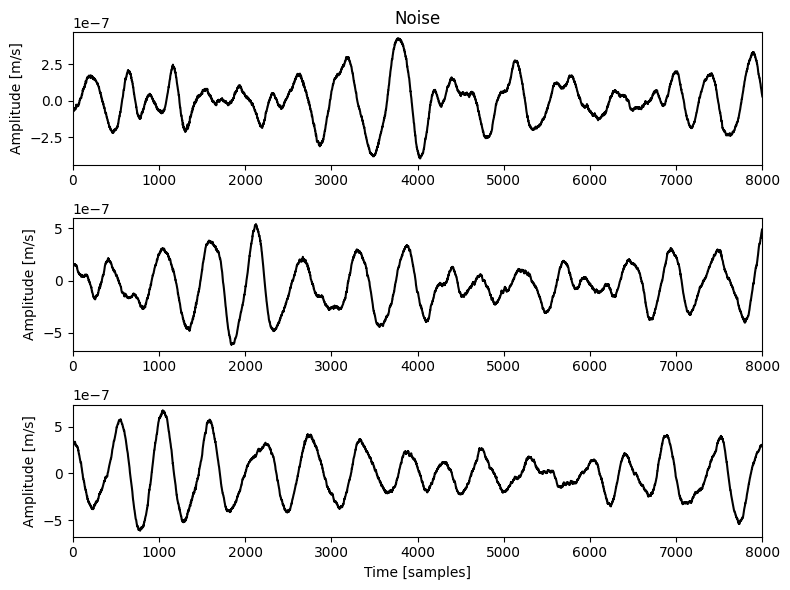

In [4]:
dir_file = "./examples/noise_2023_003_033559_CH_SLE.npz"
#dir_file = "./examples/noise_2023_003_053339_CH_ZUR.npz"

data_npz = np.load(dir_file, allow_pickle=True)
data_noise = {key: data_npz[key] for key in data_npz}

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])  # Three rows, one column

# Create the subplots
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Data for each plot
waveforms = ["noise_waveform_Z", "noise_waveform_N", "noise_waveform_E"]
axes = [ax1, ax2, ax3]

# Loop over axes to plot data and add common settings
for ax, waveform in zip(axes, waveforms):
    ax.plot(data_noise[waveform], color="k")
    ax.set_xlim(0, 8000)
    ax.set_ylabel("Amplitude [m/s]")

# Set x-label for the last axis
ax3.set_xlabel("Time [samples]")

ax1.set_title("Noise")
# Display the plot
plt.tight_layout()
plt.show()

Combine event and noise signal - vertical component

generate different combinations of event and noise signals by:
- shifting the start of the event signals in time
- changing the relative amplitude of event and noise signals - known as signal-to-nosie ratio (SNR)

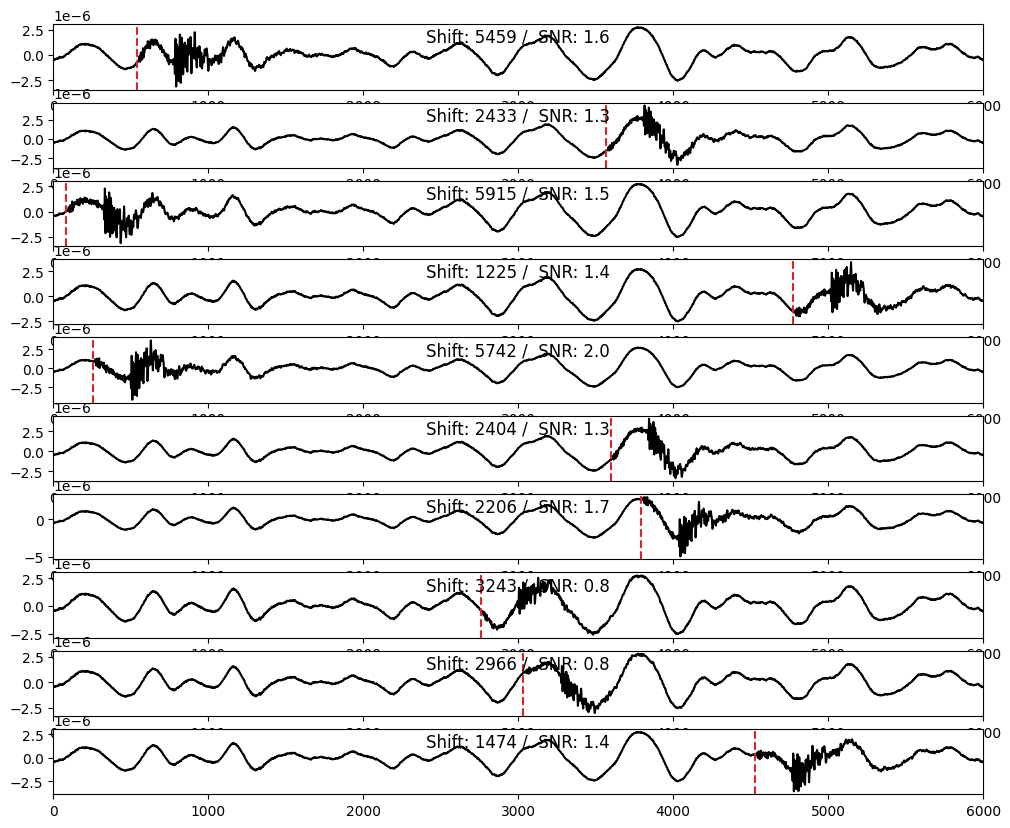

In [61]:
num_examples = 10
len_sample = 6000  # 6000 samples = 60 seconds
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(num_examples, 1)  # Three rows, one column

# generate noisy event waveforms 8event+noise) with simple variations
for i in range(num_examples):
    event = np.copy(data["earthquake_waveform_Z"])
    noise = np.copy(data_noise["noise_waveform_Z"])

    # randomly change relative amplitude of event and noise signal
    # relative amplitude = signal-to-noise ratio SNR
    # compute SNR
    signal_std = np.std(event[6000:6500])  # compute signals std over main event signal
    noise_std = np.std(noise[6000:6500])  #  compute nosie std 
    snr_original = signal_std / noise_std

    # change the SNR
    noise_snr_mod = noise * snr_original  # rescale noise so that SNR=1
    snr_random = np.random.uniform(0.5,2)  # random SNR     
    event_snr_mod = event * snr_random  # rescale event to desired SNR

    # randomly shift event start
    event_shift = np.random.randint(1000,6000)    
    
    noisy_event = event_snr_mod[event_shift:len_sample+event_shift] + noise_snr_mod[:len_sample]  # randomnly cut event waveform to shorter tiem window, cut noise waveform
    
    ax = fig.add_subplot(gs[i])
    ax.plot(noisy_event,color="k")
    ax.axvline(x=6000-event_shift, color='tab:red', linestyle='--', label="Earthquake signal start")
    ax.set_xlim(0,len_sample)
    ax.set_title("Shift: " + str(event_shift) + " /  SNR: " + str(np.round(snr_random,1)),y=0.6)



Representatation of data in time-domain (time series), frequecy domain (spectrum) and time-frequency-domain (spectrogram)

Time series (time domain)

(0.0, 50.0)

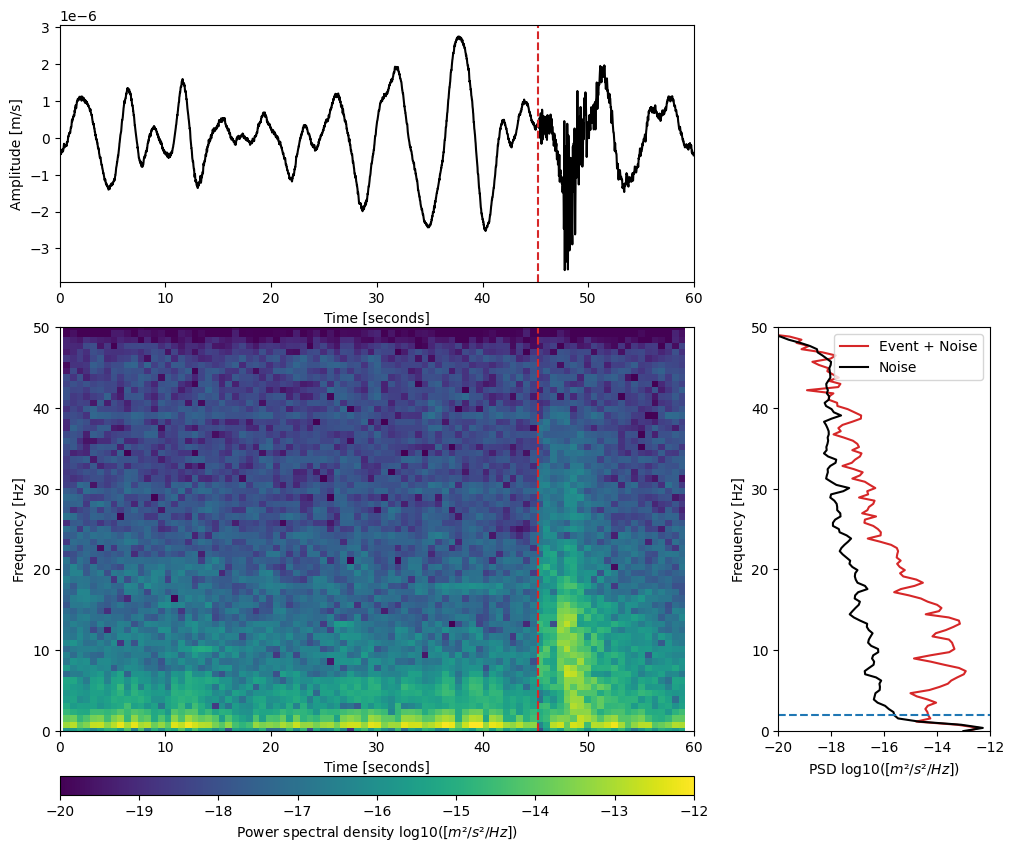

In [78]:
sampling_rate = 100 # 100 measurements per seconds

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(3, 2,height_ratios=[14,22,1],width_ratios=[3,1])

# Plot time series
ax = fig.add_subplot(gs[0])
    
ax.plot(np.linspace(0,(len(noisy_event)-1)/ sampling_rate, len(noisy_event)),noisy_event,color="k",label="Event + Noise")
ax.set_xlim(0,60)
ax.set_xlabel("Time [seconds]")
ax.set_ylabel("Amplitude [m/s]")
ax.axvline(x=(6000-event_shift)/sampling_rate, color='tab:red', linestyle='--', label="Earthquake signal start")


# Plot frequency representation
# Compute spectra
ax = fig.add_subplot(gs[3])

f, Pxx = scipy.signal.welch(noisy_event[6000-event_shift: 6000-event_shift+500], fs=sampling_rate)
ax.plot(np.log10(Pxx),f,color="tab:red",label="Event + Noise")
f, Pxx_noise = scipy.signal.welch(noise_snr_mod[:len_sample], fs=sampling_rate)
ax.plot(np.log10(Pxx_noise),f,color="k",label="Noise")
ax.legend()
ax.set_xlabel(f"PSD log10($[m²/s²/Hz]$)")
ax.set_ylabel("Frequency [Hz]")
ax.set_xlim(-20,-12)
ax.set_ylim(0,50)

ax.axhline(2,ls="--")


# Plot time-frequency representation
# Compute spectrogram
f,t, Sxx = scipy.signal.spectrogram(noisy_event, fs=sampling_rate, nperseg= 128,noverlap=64)

ax = fig.add_subplot(gs[2])
pcm = ax.pcolormesh(t,f,np.log10(Sxx),vmin=-20,vmax=-12)

cb = plt.colorbar(pcm,orientation="horizontal", cax= fig.add_subplot(gs[4]),label=f"Power spectral density log10($[m²/s²/Hz]$)")
ax.axvline(x=(6000-event_shift)/sampling_rate, color='tab:red', linestyle='--', label="Earthquake signal start")

ax.set_xlim(0,60)
ax.set_xlabel("Time [seconds]")
ax.set_ylabel("Frequency [Hz]")
ax.set_ylim(0,50)





Digital filter

bandpass filter implementation from ObSpy (seismic data processing toolbox)
https://docs.obspy.org/packages/autogen/obspy.signal.filter.bandpass.html

In [72]:
def bandpass_obspy(data, freqmin, freqmax, df, corners=4, zerophase=False):
    """
    Butterworth-Bandpass Filter.

    Filter data from ``freqmin`` to ``freqmax`` using ``corners``
    corners.
    The filter uses :func:`scipy.signal.iirfilter` (for design)
    and :func:`scipy.signal.sosfilt` (for applying the filter).

    :type data: numpy.ndarray
    :param data: Data to filter.
    :param freqmin: Pass band low corner frequency.
    :param freqmax: Pass band high corner frequency.
    :param df: Sampling rate in Hz.
    :param corners: Filter corners / order.
    :param zerophase: If True, apply filter once forwards and once backwards.
        This results in twice the filter order but zero phase shift in
        the resulting filtered trace.
    :return: Filtered data.
    """
    fe = 0.5 * df
    low = freqmin / fe
    high = freqmax / fe
    # raise for some bad scenarios
    if high - 1.0 > -1e-6:
        msg = ("Selected high corner frequency ({}) of bandpass is at or "
               "above Nyquist ({}). Applying a high-pass instead.").format(
            freqmax, fe)
        warnings.warn(msg)
        return None
    if low > 1:
        msg = "Selected low corner frequency is above Nyquist."
        raise ValueError(msg)
    z, p, k = scipy.signal.iirfilter(corners, [low, high], btype='band',
                        ftype='butter', output='zpk')
    sos = scipy.signal.zpk2sos(z, p, k)
    if zerophase:
        firstpass = sosfilt(sos, data)
        return scipy.signal.sosfilt(sos, firstpass[::-1])[::-1]
    else:
        return scipy.signal.sosfilt(sos, data)

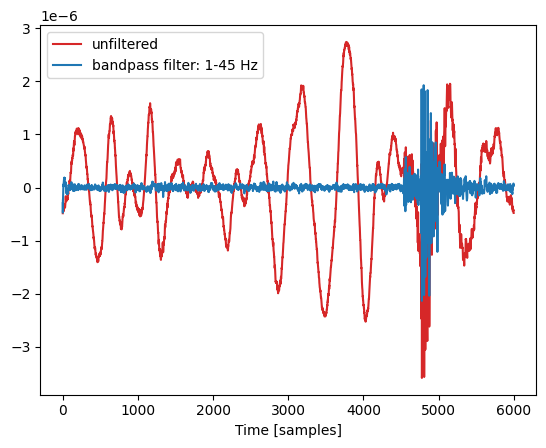

In [75]:
freq_range = [1,45]
sampling_rate = 100
noisy_event_bandpass = bandpass_obspy(noisy_event, freqmin=freq_range[0], freqmax=freq_range[1], df=sampling_rate, corners=4, zerophase=False)

plt.plot(noisy_event,color="tab:red",label="unfiltered")
plt.plot(noisy_event_bandpass,color="tab:blue", label=f"bandpass filter: {freq_range[0]}-{freq_range[1]} Hz")
plt.xlabel("Time [samples]")
plt.legend()